In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from scipy.stats import randint
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats

## Data Cleaning

In [2]:
# Import data
data = pd.read_csv(r"C:\Users\w1381\桌面\python-projects\5261\train.csv")

In [3]:
# change the blanks in far_price and near_price to mean value
far_price_mean = data['far_price'].mean()
near_price_mean = data['near_price'].mean()


# set nosies if the value exceed for three sigmas
# delete the noise of far_price and near_price
far_price_std = data['far_price'].std()
near_price_std = data['near_price'].std()
far_price_upper_limit = far_price_mean + 3 * far_price_std
far_price_lower_limit = far_price_mean - 3 * far_price_std

data = data[
    ((data['far_price'] <= far_price_upper_limit) &
    (data['far_price'] >= far_price_lower_limit)) | data['far_price'].isnull()]

data = data[
    ((data['near_price'] <= far_price_upper_limit) &
    (data['near_price'] >= far_price_lower_limit)) | data['near_price'].isnull()]


In [4]:
# Extract useful features without those ids
relevant_features = ['matched_size', 'imbalance_size', 'bid_price', 'far_price', 'near_price']
len(relevant_features)

# List of numerical features that need imputation
numerical_features = ['far_price', 'near_price']

# List of features that do not need imputation
other_features = [feature for feature in relevant_features if feature not in numerical_features]

In [5]:
# Check for missing values in the dataset
missing_values = data.isnull().sum()
missing_values

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [6]:
# Drop NA rows and input median for near and far price
data = data.dropna(subset=["imbalance_size", "matched_size", "bid_price","ask_price"])


In [7]:
# Extract X_train and y_train
X_train = data[relevant_features]
y_train = data['ask_price']


## Multiple Linear Regression

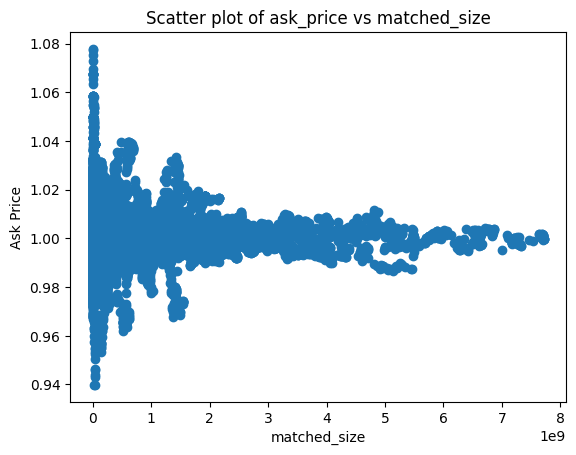

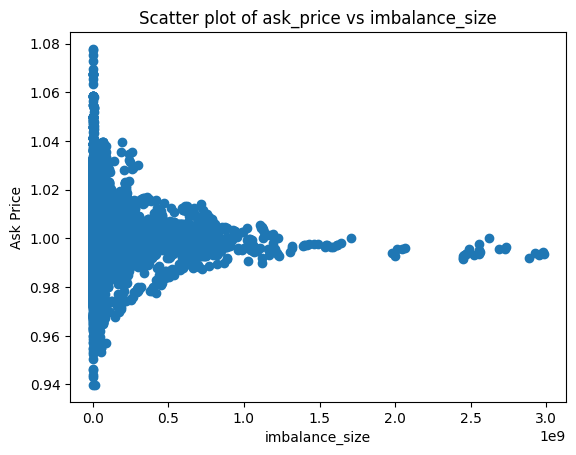

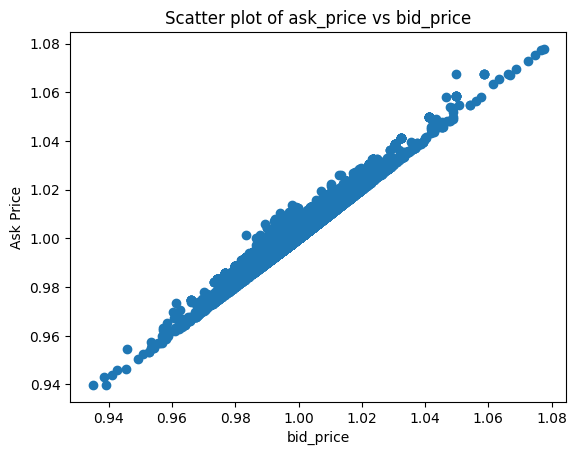

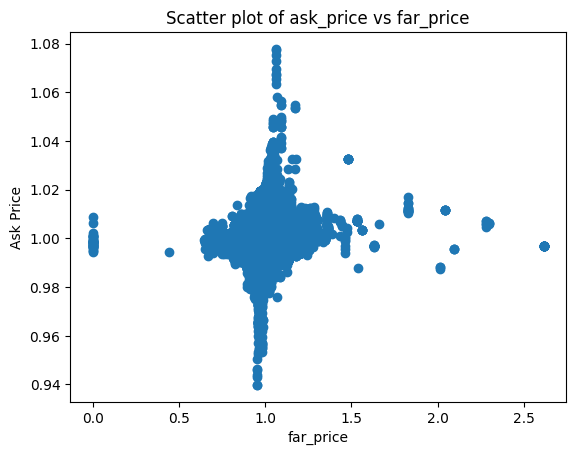

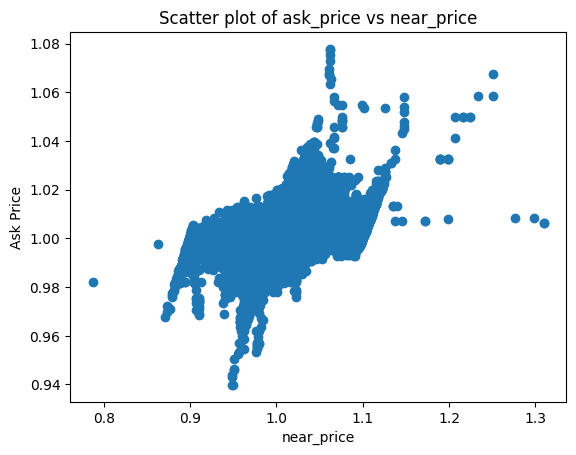

In [8]:
# We'll plot scatter plots for each independent variable against the dependent variable
for feature in relevant_features:
    plt.scatter(data[feature], data['ask_price'])
    plt.title(f'Scatter plot of ask_price vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Ask Price')
    plt.show()

In [9]:
# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('impute_scale', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('scaler', StandardScaler(), other_features)
    ]
)


In [10]:
# Create the pipeline with MLR instead of RandomForestRegressor
mlr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


In [11]:
# Now fit the MLR pipeline to your training data
mlr_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('impute_scale',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['far_price', 'near_price']),
                                                 ('scaler', StandardScaler(),
                                                  ['matched_size',
                                                   'imbalance_size',
                                                   'bid_price'])])),
                ('regressor', LinearRegression())])

In [12]:
# Perform cross-validation
cv_scores = cross_val_score(mlr_pipeline, X_train, y_train, cv=5, scoring= "neg_mean_squared_error")
-cv_scores

array([2.48293462e-07, 2.84530364e-07, 2.46698867e-07, 4.00261374e-07,
       4.79443589e-07])

## Random Forests Regression

In [13]:
# resample 1% of the data (original dataset is too large over 6m rows)
sampled_data = data.sample(frac=0.1, random_state=83)  # Randomly sample 10% of the data

In [14]:
# Extract X_train and y_train
X_train_sample = sampled_data[relevant_features]
y_train_sample = sampled_data['ask_price']

In [15]:
# Create the pipeline with the preprocessor and the RandomForestRegressor
RF_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_jobs= - 1))
])

In [16]:
# Fit the RF_pipeline model
RF_pipeline.fit(X_train_sample, y_train_sample)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('impute_scale',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['far_price', 'near_price']),
                                                 ('scaler', StandardScaler(),
                                                  ['matched_size',
                                                   'imbalance_size',
                                                   'bid_price'])])),
                ('regressor', RandomForestRegressor(n_jobs=-1))])

In [17]:
# Get the feature importances
feature_importances = RF_pipeline.named_steps['regressor'].feature_importances_
print(feature_importances)

# Retrieve feature importances and map them to the corresponding feature names
feature_names = preprocessor.get_feature_names_out()

# Create a DataFrame to hold feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by feature importances
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the feature importances
importance_df

[0.00268357 0.00441666 0.02546648 0.00903912 0.95839417]


,Feature,Importance
4,scaler__bid_price,0.958394
2,scaler__matched_size,0.025466
3,scaler__imbalance_size,0.009039
1,impute_scale__near_price,0.004417
0,impute_scale__far_price,0.002684


In [18]:
# Define the parameter distribution for RandomForestRegressor with a reduced range and simpler models
param_dist = {
    'regressor__n_estimators': randint(20, 50),  # fewer trees
    'regressor__max_depth': [5, 10],  # fewer options for max depth
    'regressor__min_samples_split': randint(6, 10), # fewer split
    'regressor__min_samples_leaf': randint(4, 6) # fewer leaves
}


# Instantiate the RandomizedSearchCV object with the pipeline and parameter distribution
random_search = RandomizedSearchCV(RF_pipeline, param_distributions=param_dist,
                                   n_iter=5,  # fewer iterations
                                   cv=3,
                                   scoring='neg_mean_squared_error',
                                   n_jobs=-1)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train_sample, y_train_sample)

# View the best parameters from the hyperparameter tuning
print("Best hyperparameters:", random_search.best_params_)

# View the best score found during the search
print("Best MSE score from Random Search:", -random_search.best_score_)

Best hyperparameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 6, 'regressor__n_estimators': 38}
Best MSE score from Random Search: 2.1935061173441974e-07


In [19]:
# Extract the best model from randomized search
RF_best_model = random_search.best_estimator_



In [20]:
# Import test data
test_data = pd.read_csv(r"C:\Users\w1381\桌面\python-projects\5261\test.csv")

In [21]:
# Extract X_test and y_test
X_test = test_data.dropna(subset=["imbalance_size", "matched_size", "bid_price","ask_price"])
y_test = test_data["ask_price"]

In [22]:
# Make prediction using RF_best_model
y_pred = RF_best_model.predict(X_test)


In [23]:
# Calculate MSE and MAE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(mse)
print(mae)


2.0503430265422487e-07
0.00027186249540430823


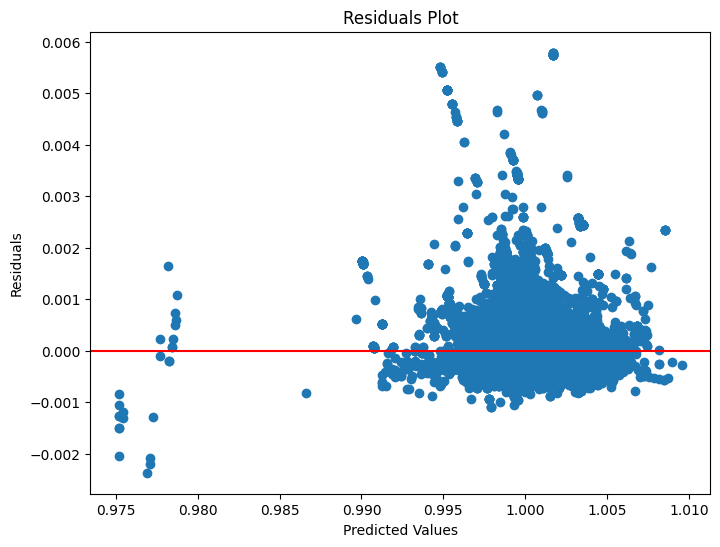

In [24]:
# Calculate residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=[8, 6])
plt.scatter(y_pred, residuals)
plt.title('Residuals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

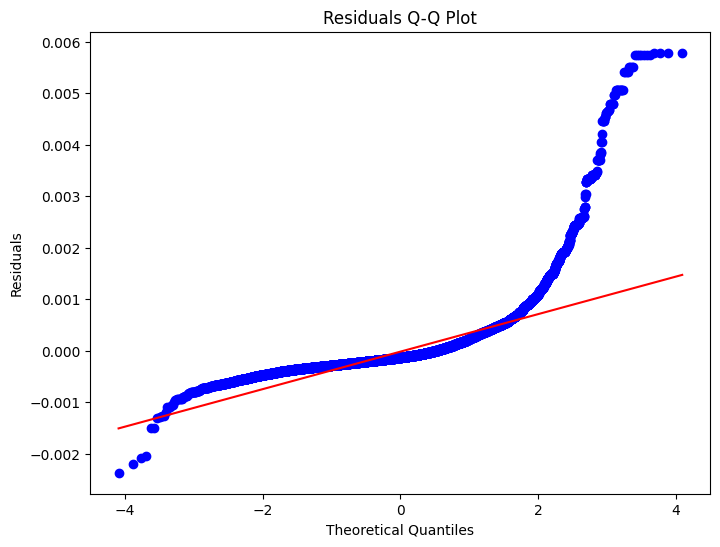

In [25]:
# Generate a Q-Q plot for the residuals
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Residuals Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Residuals')

# The line shows the distribution if the residuals were normal
plt.show()

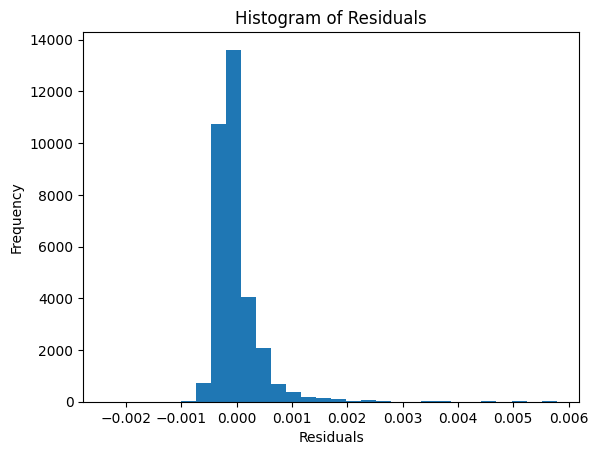

In [26]:
# Plot the histogram of residuals
plt.hist(residuals, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


## Below is VaR

In [27]:
import numpy as np
from scipy.stats import norm

df = data.copy()
# Your existing code for setting up and fitting the GJR-GARCH model
df['log_ask_price_returns'] = np.log(df['ask_price'] / df['ask_price'].shift(1))
df = df.replace([np.inf, -np.inf], np.nan).dropna()

# Calculate the mean and standard deviation (volatility) of returns
mean_returns = np.exp(df['log_ask_price_returns']).mean()
std_dev_returns = np.exp(df['log_ask_price_returns']).std()

# Define the confidence level
confidence_level = 0.95

# Calculate VaR using the variance-covariance method
VaR = norm.ppf(confidence_level, mean_returns, std_dev_returns)
print(f"VaR at {confidence_level * 100}% confidence level: {VaR}")


VaR at 95.0% confidence level: 1.0057842213004762
